# Segmentation

## File Renaming

In [1]:
import os
def rename_files_sequentially(root_folder):
    for subdir, _, files in os.walk(root_folder):
        if files:  
            subfolder_name = os.path.basename(subdir)  # Get the subfolder name
            counter = 1  # Initialize a counter for sequential numbering

            for file in files:
                file_path = os.path.join(subdir, file)  # Full path to the file
                file_extension = os.path.splitext(file)[1].lower()  # Get the file extension and convert to lowercase
                new_file_name = f"{subfolder_name}{counter}{file_extension}"  # New file name
                new_file_path = os.path.join(subdir, new_file_name)  # Full path to the new file

                # Rename the file
                os.rename(file_path, new_file_path)
                print(f"Renamed: {file} -> {new_file_name}")
                counter += 1  # Increment the counter

# Specify the root folder path
root_folder = r"D:\Virtual Environments\Pattern Recognition\final dataset\Tomato___Tomato_Yellow_Leaf_Curl_Virus"
# Call the function
rename_files_sequentially(root_folder)

## Visualizing Segmentation

### Visualization Function

In [2]:
import matplotlib.pyplot as plt
def visualize(original, updated):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Segmented image')
  plt.imshow(updated)

### Visualizing Segmentation

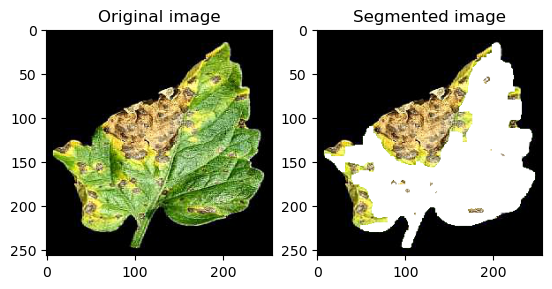

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from rembg import remove

image = Image.open(r"D:\Virtual Environments\Pattern Recognition\split dataset\train\Tomato___Septoria_leaf_spot\Tomato___Septoria_leaf_spot192.jpg").convert("RGB")

leaf_mask = segment_leaf_image_processing(image)
affected_mask = identify_affected_regions(image, leaf_mask)
combined_region_image = extract_affected_region(image, leaf_mask, affected_mask)
segmented_image = combined_region_image

if combined_region_image.mode == 'RGBA':
    combined_region_image = combined_region_image.convert('RGB')

visualize(image, segmented_image)


## Segmentation Functions

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from rembg import remove

def segment_leaf_image_processing(image):
    """Segments the leaf from the background using color filtering."""
    image_np = np.array(image)  # Convert image to NumPy array
    hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)

    # Define green color range
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])

    healthy_mask = cv2.inRange(hsv, lower_green, upper_green)

    # Apply morphological operations
    kernel = np.ones((5, 5), np.uint8)
    healthy_mask = cv2.morphologyEx(healthy_mask, cv2.MORPH_CLOSE, kernel)
    healthy_mask = cv2.morphologyEx(healthy_mask, cv2.MORPH_OPEN, kernel)

    # Find and extract the largest contour
    contours, _ = cv2.findContours(healthy_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    leaf_mask = np.zeros_like(healthy_mask)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(leaf_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    return leaf_mask

# def segment_leaf_image_processing(image):
#     """Segments the leaf from the background using multiple green color ranges."""
#     image_np = np.array(image)  # Convert image to NumPy array
#     hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)

#     # Define multiple green color ranges
#     green_ranges = [
#         ([35, 100, 100], [50, 255, 255]),  # Bright Green
#         ([50, 50, 50], [70, 255, 200]),    # Dark Green
#         ([85, 100, 100], [100, 255, 255])  # Bluish Green
#     ]

#     # Initialize the healthy mask
#     healthy_mask = np.zeros(hsv.shape[:2], dtype=np.uint8)

#     # Combine masks for all green ranges
#     for lower, upper in green_ranges:
#         lower_np = np.array(lower, dtype=np.uint8)
#         upper_np = np.array(upper, dtype=np.uint8)
#         mask = cv2.inRange(hsv, lower_np, upper_np)
#         healthy_mask = cv2.bitwise_or(healthy_mask, mask)

#     # Apply morphological operations to clean up the mask
#     kernel = np.ones((5, 5), np.uint8)
#     healthy_mask = cv2.morphologyEx(healthy_mask, cv2.MORPH_CLOSE, kernel)
#     healthy_mask = cv2.morphologyEx(healthy_mask, cv2.MORPH_OPEN, kernel)

#     # Find and extract the largest contour (assumed to be the leaf)
#     contours, _ = cv2.findContours(healthy_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     leaf_mask = np.zeros_like(healthy_mask)
#     if contours:
#         largest_contour = max(contours, key=cv2.contourArea)
#         cv2.drawContours(leaf_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

#     return leaf_mask


def identify_affected_regions(image, leaf_mask):
    """Identifies affected regions on the leaf based on color thresholding."""
    image_np = np.array(image)
    hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)

    # Define affected region color range
    lower_affected = np.array([10, 50, 50])
    upper_affected = np.array([25, 255, 255])

    affected_mask = cv2.inRange(hsv, lower_affected, upper_affected)
    affected_mask = cv2.bitwise_and(affected_mask, affected_mask, mask=leaf_mask)

    return affected_mask

def extract_affected_region(image, leaf_mask, affected_mask):
    """Extracts affected areas and removes background."""
    image_np = np.array(image)
    non_green_mask = cv2.bitwise_not(leaf_mask)
    combined_mask = cv2.bitwise_or(non_green_mask, affected_mask)
    combined_region = cv2.bitwise_and(image_np, image_np, mask=combined_mask)

    # Handle transparency (if RGBA)
    if image_np.shape[-1] == 4:
        combined_region[combined_mask == 0, 3] = 0  # Set transparent pixels
    else:
        combined_region[combined_mask == 0] = [255, 255, 255]  # Set background to white

    return Image.fromarray(combined_region)


# Automation

In [4]:
def process_and_save_images(input_folder, output_folder):
    """Processes all images in the input folder and saves results."""
    for subdir, _, files in os.walk(input_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                input_image_path = os.path.join(subdir, file)
                print(f"Processing: {input_image_path}")

                # Open image properly
                image = Image.open(input_image_path).convert("RGB")

                # Process the image
                leaf_mask = segment_leaf_image_processing(image)
                affected_mask = identify_affected_regions(image, leaf_mask)
                combined_region_image = extract_affected_region(image, leaf_mask, affected_mask)

                # Convert to RGB if in RGBA mode
                if combined_region_image.mode == 'RGBA':
                    combined_region_image = combined_region_image.convert('RGB')

                # Create output directory structure
                relative_path = os.path.relpath(subdir, input_folder)
                output_subfolder = os.path.join(output_folder, relative_path)
                os.makedirs(output_subfolder, exist_ok=True)

                # Save the processed image
                output_image_path = os.path.join(output_subfolder, file)
                combined_region_image.save(output_image_path)
                print(f"Saved: {output_image_path}")

# Automating Segmentation (Train Split)

In [ ]:
train_input_folder = r"D:\Virtual Environments\Pattern Recognition\split dataset\train"
train_output_folder = r"D:\Virtual Environments\Pattern Recognition\segmented dataset\train"
process_and_save_images(train_input_folder, train_output_folder)

Processing: D:\Virtual Environments\Pattern Recognition\split dataset\train\Tomato___Bacterial_spot\Tomato___Bacterial_spot1.jpg
Saved: D:\Virtual Environments\Pattern Recognition\segmented dataset\train\Tomato___Bacterial_spot\Tomato___Bacterial_spot1.jpg
Processing: D:\Virtual Environments\Pattern Recognition\split dataset\train\Tomato___Bacterial_spot\Tomato___Bacterial_spot10.jpg
Saved: D:\Virtual Environments\Pattern Recognition\segmented dataset\train\Tomato___Bacterial_spot\Tomato___Bacterial_spot10.jpg
Processing: D:\Virtual Environments\Pattern Recognition\split dataset\train\Tomato___Bacterial_spot\Tomato___Bacterial_spot1000.jpg
Saved: D:\Virtual Environments\Pattern Recognition\segmented dataset\train\Tomato___Bacterial_spot\Tomato___Bacterial_spot1000.jpg
Processing: D:\Virtual Environments\Pattern Recognition\split dataset\train\Tomato___Bacterial_spot\Tomato___Bacterial_spot1001.jpg
Saved: D:\Virtual Environments\Pattern Recognition\segmented dataset\train\Tomato___Bacte

# Automating Segmentation (Validation Split)

In [ ]:
# Input and output folders
validation_input_folder = r"D:\Virtual Environments\Pattern Recognition\split dataset\validation"
validation_output_folder = r"D:\Virtual Environments\Pattern Recognition\segmented dataset\validation"
process_and_save_images(validation_input_folder, validation_output_folder)

# Automating Segmentation (Test Split)

In [5]:
# Input and output folders
test_input_folder = r"D:\Virtual Environments\Pattern Recognition\split dataset\test"
test_output_folder = r"D:\Virtual Environments\Pattern Recognition\segmented dataset\test"
process_and_save_images(test_input_folder, test_output_folder)

Processing: D:\Virtual Environments\Pattern Recognition\split dataset\test\Tomato___Bacterial_spot\Tomato___Bacterial_spot1002.jpg
Saved: D:\Virtual Environments\Pattern Recognition\segmented dataset\test\Tomato___Bacterial_spot\Tomato___Bacterial_spot1002.jpg
Processing: D:\Virtual Environments\Pattern Recognition\split dataset\test\Tomato___Bacterial_spot\Tomato___Bacterial_spot1007.jpg
Saved: D:\Virtual Environments\Pattern Recognition\segmented dataset\test\Tomato___Bacterial_spot\Tomato___Bacterial_spot1007.jpg
Processing: D:\Virtual Environments\Pattern Recognition\split dataset\test\Tomato___Bacterial_spot\Tomato___Bacterial_spot1008.jpg
Saved: D:\Virtual Environments\Pattern Recognition\segmented dataset\test\Tomato___Bacterial_spot\Tomato___Bacterial_spot1008.jpg
Processing: D:\Virtual Environments\Pattern Recognition\split dataset\test\Tomato___Bacterial_spot\Tomato___Bacterial_spot1020.jpg
Saved: D:\Virtual Environments\Pattern Recognition\segmented dataset\test\Tomato___Bac